In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.metrics import r2_score
import scipy.optimize

cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']

In [2]:
city='Berlin'
df=pd.read_csv('../outputs/summary_stats/Berlin_stats.csv')
df['City']=city
df_all=df.copy()

for city in ['Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']:
    df=pd.read_csv('../outputs/summary_stats/' + city + '_stats.csv')
    df['City']=city
    df_all=pd.concat([df_all,df])
df_all

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City
0,2_3_Wheel,0.169473,0.009567,NaN,NaN,Berlin
1,Bike,2.204074,0.124421,NaN,NaN,Berlin
2,Car,6.970883,0.393511,0.595803,NaN,Berlin
3,Foot,0.925913,0.052268,NaN,NaN,Berlin
4,Transit,7.444241,0.420232,NaN,NaN,Berlin
...,...,...,...,...,...,...
2,Car,10.389040,0.471215,0.753439,NaN,Wien
3,Foot,0.856306,0.038839,NaN,NaN,Wien
4,Transit,10.242574,0.464572,NaN,NaN,Wien
5,All,22.047345,NaN,NaN,7.515434,Wien


In [3]:
# convert to %
df_all['Mode_Share']=df_all['Mode_Share']*100

In [4]:
summ_UF=pd.read_csv('../outputs/summary_stats/summary_UF_all.csv')
summ_UF.rename(columns={'cities':'City'},inplace=True)
summ_UF['Pop.']=summ_UF['Population'].replace(',','',regex=True).astype(int)*1e-6
summ_UF

,City,Population,Area,Pop. density,Built-up density,Dist. to center,Dist. to subcenter,Instersec. density,Street length avg.,Cycle lane share,Urban fabric area,Commercial area,Unnamed: 12,Unnamed: 13,Pop.
0,Berlin,"3,303,002",896,3687,1.10,8.50,2.45,23.65,144.0,5%,25%,10%,NaN,3.303,3.303002
1,Dresden,"512,829",328,1562,0.54,4.73,2.93,18.02,140.3,9%,14%,7%,NaN,0.513,0.512829
2,Düsseldorf,"586,399",215,2724,1.07,4.34,2.50,27.54,116.9,9%,20%,14%,NaN,0.586,0.586399
3,Frankfurt am Main,"704,016",253,2785,0.30,4.86,2.16,27.64,121.4,17%,12%,12%,NaN,0.704,0.704016
4,Kassel,"190,786",108,1765,0.14,3.16,2.75,25.58,124.9,4%,19%,9%,NaN,0.191,0.190786
5,Leipzig,"503,235",298,1689,0.74,4.43,2.61,20.96,130.2,8%,13%,12%,NaN,0.503,0.503235
6,Magdeburg,"228,201",202,1131,0.63,2.94,1.73,15.54,145.3,5%,10%,8%,NaN,0.228,0.228201
7,Potsdam,"155,925",188,828,0.26,4.15,2.27,10.61,147.2,5%,5%,3%,NaN,0.156,0.155925
8,Clermont,"284,830",311,915,0.45,3.99,2.73,25.31,97.5,3%,12%,8%,NaN,0.285,0.284830
9,Dijon,"253,637",241,1052,0.40,2.90,2.68,21.70,105.9,3%,8%,8%,NaN,0.254,0.253637


In [5]:
df_all=df_all.merge(summ_UF.loc[:,['City','Population','Dist. to center','Pop. density','Pop.']])
df_all

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City,Population,Dist. to center,Pop. density,Pop.
0,2_3_Wheel,0.169473,0.956685,NaN,NaN,Berlin,"3,303,002",8.50,3687,3.303002
1,Bike,2.204074,12.442144,NaN,NaN,Berlin,"3,303,002",8.50,3687,3.303002
2,Car,6.970883,39.351096,0.595803,NaN,Berlin,"3,303,002",8.50,3687,3.303002
3,Foot,0.925913,5.226840,NaN,NaN,Berlin,"3,303,002",8.50,3687,3.303002
4,Transit,7.444241,42.023236,NaN,NaN,Berlin,"3,303,002",8.50,3687,3.303002
...,...,...,...,...,...,...,...,...,...,...
128,Car,10.389040,47.121502,0.753439,NaN,Wien,"1,871,960",6.47,2185,1.871960
129,Foot,0.856306,3.883943,NaN,NaN,Wien,"1,871,960",6.47,2185,1.871960
130,Transit,10.242574,46.457176,NaN,NaN,Wien,"1,871,960",6.47,2185,1.871960
131,All,22.047345,NaN,NaN,7.515434,Wien,"1,871,960",6.47,2185,1.871960


In [6]:
df_all.sort_values(by='Pop. density',ascending=False,inplace=True)
df_all

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City,Population,Dist. to center,Pop. density,Pop.
110,All,13.551680,NaN,NaN,3.694674,Paris,"6,941,530",8.66,8514,6.941530
111,Commute,NaN,NaN,NaN,8.656272,Paris,"6,941,530",8.66,8514,6.941530
105,2_3_Wheel,0.365380,2.696200,NaN,NaN,Paris,"6,941,530",8.66,8514,6.941530
106,Bike,0.142129,1.048791,NaN,NaN,Paris,"6,941,530",8.66,8514,6.941530
107,Car,5.255074,38.778025,0.678733,NaN,Paris,"6,941,530",8.66,8514,6.941530
...,...,...,...,...,...,...,...,...,...,...
52,Foot,0.698697,4.266938,NaN,NaN,Potsdam,"155,925",4.15,828,0.155925
50,Bike,2.219062,13.551789,NaN,NaN,Potsdam,"155,925",4.15,828,0.155925
54,All,16.374683,NaN,NaN,5.058851,Potsdam,"155,925",4.15,828,0.155925
55,Commute,NaN,NaN,NaN,11.895023,Potsdam,"155,925",4.15,828,0.155925


In [7]:
df_mode=df_all.loc[:,['City','Pop. density','Mode_Share','Mode']]
#df_mode=df_all.drop(columns=['Daily_Travel_cap','Pop.','Area','Pop. Density'])

In [8]:
df_plot=pd.pivot(df_mode,index='City',columns='Mode',values='Mode_Share').reset_index()
df_plot=df_plot.merge(df_all.loc[:,['City','Pop. density']])
df_plot.sort_values(by='Pop. density',ascending=False,inplace=True)
df_plot.drop(columns='Pop. density',inplace=True)
df_plot.drop_duplicates(inplace=True)
df_plot.rename(columns={'2_3_Wheel':'2/3 Wheel'}, inplace=True)
df_plot=df_plot.loc[:,['City','Car','2/3 Wheel','Transit','Bike','Foot']]
df_plot

,City,Car,2/3 Wheel,Transit,Bike,Foot
111,Paris,38.778025,2.696200,52.282223,1.048791,5.194760
70,Madrid,54.803366,1.284193,39.012880,0.262328,4.637233
1,Berlin,39.351096,0.956685,42.023236,12.442144,5.226840
39,Frankfurt am Main,53.579208,1.392019,26.635899,12.892853,5.500021
29,Düsseldorf,56.248817,0.750340,26.624881,10.861446,5.514516
63,Lyon,63.847244,0.975108,28.008748,1.071363,6.097536
132,Wien,47.121502,0.696782,46.457176,1.840597,3.883943
57,Lille,77.705906,0.398467,16.119543,0.919410,4.856673
43,Kassel,59.347146,0.365961,22.014622,9.978454,8.293817
50,Leipzig,56.643452,0.843822,22.185144,14.062421,6.265161


In [9]:
df_comp=df_plot.merge(summ_UF.loc[:,['City','Population','Pop. density']])
df_comp

,City,Car,2/3 Wheel,Transit,Bike,Foot,Population,Pop. density
0,Paris,38.778025,2.696200,52.282223,1.048791,5.194760,"6,941,530",8514
1,Madrid,54.803366,1.284193,39.012880,0.262328,4.637233,"5,279,092",3902
2,Berlin,39.351096,0.956685,42.023236,12.442144,5.226840,"3,303,002",3687
3,Frankfurt am Main,53.579208,1.392019,26.635899,12.892853,5.500021,"704,016",2785
4,Düsseldorf,56.248817,0.750340,26.624881,10.861446,5.514516,"586,399",2724
5,Lyon,63.847244,0.975108,28.008748,1.071363,6.097536,"1,382,539",2517
6,Wien,47.121502,0.696782,46.457176,1.840597,3.883943,"1,871,960",2185
7,Lille,77.705906,0.398467,16.119543,0.919410,4.856673,"1,140,053",1859
8,Kassel,59.347146,0.365961,22.014622,9.978454,8.293817,"190,786",1765
9,Leipzig,56.643452,0.843822,22.185144,14.062421,6.265161,"503,235",1689


In [10]:
df_car_travel=df_all.loc[df_all['Mode']=='Car',]
df_car_travel['Country']='DE'
df_car_travel.loc[df_car_travel['City'].isin(['Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse']),'Country']='FR'
df_car_travel.loc[df_car_travel['City']=='Madrid','Country']='ES'
df_car_travel.loc[df_car_travel['City']=='Wien','Country']='AT'
df_car_travel

C:\Users\peter\AppData\Local\Temp\ipykernel_5884\1310161574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_car_travel['Country']='DE'


,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City,Population,Dist. to center,Pop. density,Pop.,Country
107,Car,5.255074,38.778025,0.678733,NaN,Paris,"6,941,530",8.66,8514,6.941530,FR
121,Car,7.932258,54.803366,0.764525,NaN,Madrid,"5,279,092",9.41,3902,5.279092,ES
2,Car,6.970883,39.351096,0.595803,NaN,Berlin,"3,303,002",8.50,3687,3.303002,DE
23,Car,8.506865,53.579208,0.778925,NaN,Frankfurt am Main,"704,016",4.86,2785,0.704016,DE
16,Car,9.056565,56.248817,0.751015,NaN,Düsseldorf,"586,399",4.34,2724,0.586399,DE
79,Car,11.232382,63.847244,0.745691,NaN,Lyon,"1,382,539",5.71,2517,1.382539,FR
128,Car,10.389040,47.121502,0.753439,NaN,Wien,"1,871,960",6.47,2185,1.871960,AT
72,Car,15.157515,77.705906,0.758647,NaN,Lille,"1,140,053",7.14,1859,1.140053,FR
30,Car,8.111347,59.347146,0.748058,NaN,Kassel,"190,786",3.16,1765,0.190786,DE
37,Car,8.418088,56.643452,0.676465,NaN,Leipzig,"503,235",4.43,1689,0.503235,DE


In [11]:
df_car_travel=df_all.loc[df_all['Mode']=='Car',]
df_car_travel['Country']='Germany'
df_car_travel.loc[df_car_travel['City'].isin(['Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse']),'Country']='France'
df_car_travel.loc[df_car_travel['City']=='Madrid','Country']='Spain'
df_car_travel.loc[df_car_travel['City']=='Wien','Country']='Austria'

C:\Users\peter\AppData\Local\Temp\ipykernel_5884\277625051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_car_travel['Country']='Germany'


In [12]:
df_car_travel.reset_index(inplace=True,drop=True)
df_car_travel

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City,Population,Dist. to center,Pop. density,Pop.,Country
0,Car,5.255074,38.778025,0.678733,NaN,Paris,"6,941,530",8.66,8514,6.941530,France
1,Car,7.932258,54.803366,0.764525,NaN,Madrid,"5,279,092",9.41,3902,5.279092,Spain
2,Car,6.970883,39.351096,0.595803,NaN,Berlin,"3,303,002",8.50,3687,3.303002,Germany
3,Car,8.506865,53.579208,0.778925,NaN,Frankfurt am Main,"704,016",4.86,2785,0.704016,Germany
4,Car,9.056565,56.248817,0.751015,NaN,Düsseldorf,"586,399",4.34,2724,0.586399,Germany
5,Car,11.232382,63.847244,0.745691,NaN,Lyon,"1,382,539",5.71,2517,1.382539,France
6,Car,10.389040,47.121502,0.753439,NaN,Wien,"1,871,960",6.47,2185,1.871960,Austria
7,Car,15.157515,77.705906,0.758647,NaN,Lille,"1,140,053",7.14,1859,1.140053,France
8,Car,8.111347,59.347146,0.748058,NaN,Kassel,"190,786",3.16,1765,0.190786,Germany
9,Car,8.418088,56.643452,0.676465,NaN,Leipzig,"503,235",4.43,1689,0.503235,Germany


In [11]:
# x=df_car_travel['Pop. density']
# y=df_car_travel['Daily_Travel_cap']
# #y=df_car_travel['Mode_Share']
# n=100
# x_fitted = np.linspace(np.min(x), np.max(x), n)

# a=np.exp(np.polyfit(x, np.log(y), 1)[1])
# b=np.polyfit(x, np.log(y), 1)[0]
# y_fit=a * np.exp(b * x_fitted)

# r2=r2_score(y, a * np.exp(b * x))
# Slope=b
# xy=pd.DataFrame({'x_fit':x_fitted,'y_fit':y_fit,'R2':r2,'Slope/Beta':Slope})

In [16]:
df_car_travel

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City,Population,Dist. to center,Pop. density,Pop.,Country
0,Car,5.255074,38.778025,0.678733,NaN,Paris,"6,941,530",8.66,8514,6.941530,France
1,Car,7.932258,54.803366,0.764525,NaN,Madrid,"5,279,092",9.41,3902,5.279092,Spain
2,Car,6.970883,39.351096,0.595803,NaN,Berlin,"3,303,002",8.50,3687,3.303002,Germany
3,Car,8.506865,53.579208,0.778925,NaN,Frankfurt am Main,"704,016",4.86,2785,0.704016,Germany
4,Car,9.056565,56.248817,0.751015,NaN,Düsseldorf,"586,399",4.34,2724,0.586399,Germany
5,Car,11.232382,63.847244,0.745691,NaN,Lyon,"1,382,539",5.71,2517,1.382539,France
6,Car,10.389040,47.121502,0.753439,NaN,Wien,"1,871,960",6.47,2185,1.871960,Austria
7,Car,15.157515,77.705906,0.758647,NaN,Lille,"1,140,053",7.14,1859,1.140053,France
8,Car,8.111347,59.347146,0.748058,NaN,Kassel,"190,786",3.16,1765,0.190786,Germany
9,Car,8.418088,56.643452,0.676465,NaN,Leipzig,"503,235",4.43,1689,0.503235,Germany


<AxesSubplot:xlabel='Dist. to center', ylabel='Daily_Travel_cap'>

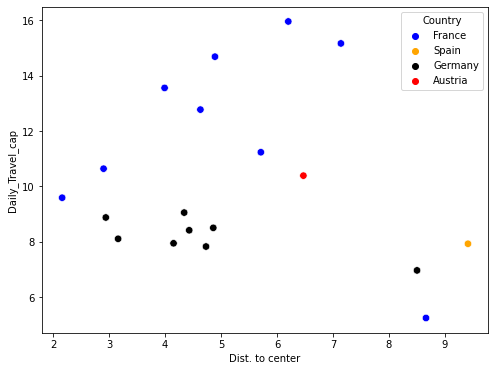

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(ax=ax,x='Dist. to center', y='Daily_Travel_cap', data=df_car_travel, hue='Country',alpha=1,s=55)

0.232


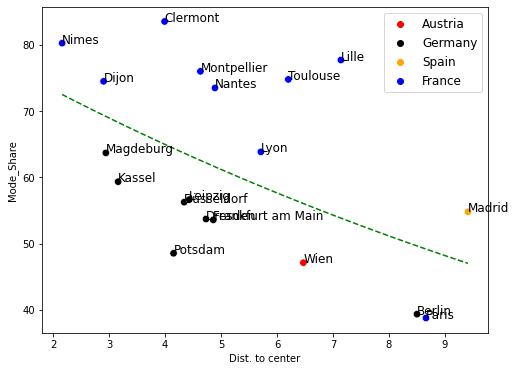

In [24]:
x=df_car_travel['Dist. to center']
#y=df_car_travel['Daily_Travel_cap']
y=df_car_travel['Mode_Share']
n=100
x_fitted = np.linspace(np.min(x), np.max(x), n)

a=np.exp(np.polyfit(x, np.log(y), 1)[1])
b=np.polyfit(x, np.log(y), 1)[0]
y_fit=a * np.exp(b * x_fitted)

r2=r2_score(y, a * np.exp(b * x))
Slope=b
xy=pd.DataFrame({'x_fit':x_fitted,'y_fit':y_fit,'R2':r2,'Slope/Beta':Slope})

colors=['blue','orange','black','red']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(ax=ax,x='Dist. to center', y='Mode_Share', data=df_car_travel, hue='Country',alpha=1,s=55)
sns.lineplot(x='x_fit', y='y_fit', data=xy,alpha=1,color='green',linestyle="dashed")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#plt.xlim(250, 9200)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=12)
# for i, l in enumerate (df_car_travel['City']):
#     if l=='Dresden':
#         plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Daily_Travel_cap'][i]-0.3), fontsize=12)
#     elif l== 'Potsdam':
#         plt.annotate(l, (df_car_travel['Pop. density'][i]-120, df_car_travel['Daily_Travel_cap'][i]+0.25), fontsize=12)
#     elif l== 'Kassel':
#         plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Daily_Travel_cap'][i]-0.15), fontsize=12)        
#     else:
#         plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Daily_Travel_cap'][i]), fontsize=12)
for i, l in enumerate (df_car_travel['City']):
    plt.annotate(l, (df_car_travel['Dist. to center'][i], df_car_travel['Mode_Share'][i]), fontsize=12)
# plt.title('a) Daily car travel vs D2C, aggregate',fontsize=18)
# plt.xlabel('Density (per/km2)',fontsize=16)
# plt.ylabel('Distance by car (km/cap/day)',fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.annotate('$r^2$='+round(r2,3).astype(str),(7000,12),fontsize=14)
print(round(r2,3))
#plt.savefig('../figures/summary_all/Daily_car_travel_vs_Density_agg.png',facecolor='w',dpi=300,bbox_inches='tight')

0.299


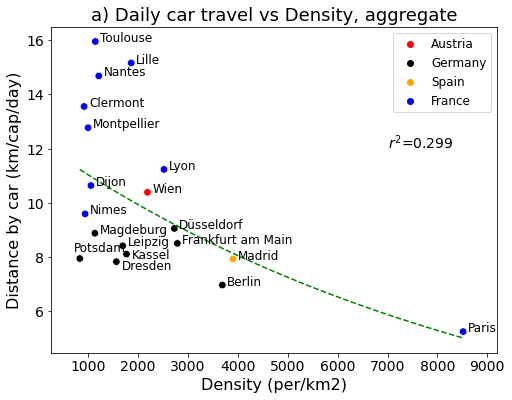

In [107]:
x=df_car_travel['Pop. density']
y=df_car_travel['Daily_Travel_cap']
#y=df_car_travel['Mode_Share']
n=100
x_fitted = np.linspace(np.min(x), np.max(x), n)

a=np.exp(np.polyfit(x, np.log(y), 1)[1])
b=np.polyfit(x, np.log(y), 1)[0]
y_fit=a * np.exp(b * x_fitted)

r2=r2_score(y, a * np.exp(b * x))
Slope=b
xy=pd.DataFrame({'x_fit':x_fitted,'y_fit':y_fit,'R2':r2,'Slope/Beta':Slope})

colors=['blue','orange','black','red']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(ax=ax,x='Pop. density', y='Daily_Travel_cap', data=df_car_travel, hue='Country',alpha=1,s=55)
sns.lineplot(x='x_fit', y='y_fit', data=xy,alpha=1,color='green',linestyle="dashed")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlim(250, 9200)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=12)
for i, l in enumerate (df_car_travel['City']):
    if l=='Dresden':
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Daily_Travel_cap'][i]-0.3), fontsize=12)
    elif l== 'Potsdam':
        plt.annotate(l, (df_car_travel['Pop. density'][i]-120, df_car_travel['Daily_Travel_cap'][i]+0.25), fontsize=12)
    elif l== 'Kassel':
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Daily_Travel_cap'][i]-0.15), fontsize=12)        
    else:
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Daily_Travel_cap'][i]), fontsize=12)

plt.title('a) Daily car travel vs Density, aggregate',fontsize=18)
plt.xlabel('Density (per/km2)',fontsize=16)
plt.ylabel('Distance by car (km/cap/day)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.annotate('$r^2$='+round(r2,3).astype(str),(7000,12),fontsize=14)
print(round(r2,3))
plt.savefig('../figures/summary_all/Daily_car_travel_vs_Density_agg.png',facecolor='w',dpi=300,bbox_inches='tight')

0.442


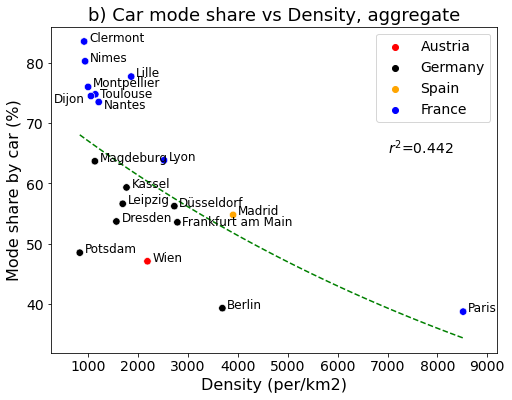

In [109]:
x=df_car_travel['Pop. density']
#y=df_car_travel['Daily_Travel_cap']
y=df_car_travel['Mode_Share']
n=100
x_fitted = np.linspace(np.min(x), np.max(x), n)

a=np.exp(np.polyfit(x, np.log(y), 1)[1])
b=np.polyfit(x, np.log(y), 1)[0]
y_fit=a * np.exp(b * x_fitted)

r2=r2_score(y, a * np.exp(b * x))
Slope=b
xy=pd.DataFrame({'x_fit':x_fitted,'y_fit':y_fit,'R2':r2,'Slope/Beta':Slope})

colors=['blue','orange','black','red']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(ax=ax,x='Pop. density', y='Mode_Share', data=df_car_travel, hue='Country',alpha=1,s=55)
sns.lineplot(x='x_fit', y='y_fit', data=xy,alpha=1,color='green',linestyle="dashed")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlim(250, 9200)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=14)
for i, l in enumerate (df_car_travel['City']):
    if l=='Nantes':
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Mode_Share'][i]-1), fontsize=12)
    elif l== 'Dijon':
        plt.annotate(l, (df_car_travel['Pop. density'][i]-750, df_car_travel['Mode_Share'][i]-1), fontsize=12)
    elif l== 'Toulouse':
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Mode_Share'][i]-0.5), fontsize=12)       
    elif l== 'Frankfurt am Main':
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Mode_Share'][i]-0.5), fontsize=12)       
    else:
        plt.annotate(l, (df_car_travel['Pop. density'][i]+100, df_car_travel['Mode_Share'][i]), fontsize=12)

plt.title('b) Car mode share vs Density, aggregate',fontsize=18)
plt.xlabel('Density (per/km2)',fontsize=16)
plt.ylabel('Mode share by car (%)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.annotate('$r^2$='+round(r2,3).astype(str),(7000,65),fontsize=14)
print(round(r2,3))
plt.savefig('../figures/summary_all/Car_mode_share_vs_Density_agg.png',facecolor='w',dpi=300,bbox_inches='tight')

In [49]:
# def monoExp(x, m, t, b):
#     return m * np.exp(-t * x) + b
# p0 = (100, .001, 20)
# params, cv = scipy.optimize.curve_fit(monoExp, x, y,p0)
# m, t, b = params

# plt.plot(x, y, '.', label="data")
# plt.plot(x_fitted, monoExp(x_fitted, m, t, b), '--', label="fitted")
# plt.title("Fitted Exponential Curve")

In [10]:
df_comp[['Transit','Car','Foot','Population','Pop. density']].corr()

,Transit,Car,Foot,Pop. density
Transit,1.000000,-0.893488,-0.393751,0.768455
Car,-0.893488,1.000000,0.178003,-0.644344
Foot,-0.393751,0.178003,1.000000,-0.136763
Pop. density,0.768455,-0.644344,-0.136763,1.000000


In [13]:
size_sort_pop=summ_UF.sort_values(by='Pop.',ascending=False).reset_index(drop=True)
size_sort_pop

,City,Population,Area,Pop. density,Built-up density,Dist. to center,Dist. to subcenter,Instersec. density,Street length avg.,Cycle lane share,Urban fabric area,Commercial area,Unnamed: 12,Unnamed: 13,Pop.
0,Paris,"6,941,530",815,8514,2.27,8.66,3.46,56.86,101.0,15%,30%,17%,NaN,6.942,6.941530
1,Madrid,"5,279,092",1353,3902,0.98,9.41,2.42,31.66,104.1,1%,11%,12%,NaN,5.279,5.279092
2,Berlin,"3,303,002",896,3687,1.10,8.50,2.45,23.65,144.0,5%,25%,10%,NaN,3.303,3.303002
3,Wien,"1,871,960",857,2185,1.10,6.47,3.30,19.67,132.5,3%,14%,7%,NaN,1.872,1.871960
4,Lyon,"1,382,539",549,2517,0.97,5.71,3.12,32.22,113.9,7%,23%,12%,NaN,1.383,1.382539
5,Lille,"1,140,053",613,1859,0.71,7.14,2.47,33.69,102.4,8%,22%,12%,NaN,1.140,1.140053
6,Toulouse,"890,843",781,1140,0.52,6.20,3.30,27.58,102.5,5%,22%,9%,NaN,0.891,0.890843
7,Frankfurt am Main,"704,016",253,2785,0.30,4.86,2.16,27.64,121.4,17%,12%,12%,NaN,0.704,0.704016
8,Nantes,"646,521",535,1208,0.47,4.89,2.69,27.68,99.4,17%,16%,9%,NaN,0.647,0.646521
9,Düsseldorf,"586,399",215,2724,1.07,4.34,2.50,27.54,116.9,9%,20%,14%,NaN,0.586,0.586399


In [14]:
size_sort_dens=summ_UF.sort_values(by='Pop. density',ascending=False).reset_index(drop=True)
size_sort_dens

,City,Population,Area,Pop. density,Built-up density,Dist. to center,Dist. to subcenter,Instersec. density,Street length avg.,Cycle lane share,Urban fabric area,Commercial area,Unnamed: 12,Unnamed: 13,Pop.
0,Paris,"6,941,530",815,8514,2.27,8.66,3.46,56.86,101.0,15%,30%,17%,NaN,6.942,6.941530
1,Madrid,"5,279,092",1353,3902,0.98,9.41,2.42,31.66,104.1,1%,11%,12%,NaN,5.279,5.279092
2,Berlin,"3,303,002",896,3687,1.10,8.50,2.45,23.65,144.0,5%,25%,10%,NaN,3.303,3.303002
3,Frankfurt am Main,"704,016",253,2785,0.30,4.86,2.16,27.64,121.4,17%,12%,12%,NaN,0.704,0.704016
4,Düsseldorf,"586,399",215,2724,1.07,4.34,2.50,27.54,116.9,9%,20%,14%,NaN,0.586,0.586399
5,Lyon,"1,382,539",549,2517,0.97,5.71,3.12,32.22,113.9,7%,23%,12%,NaN,1.383,1.382539
6,Wien,"1,871,960",857,2185,1.10,6.47,3.30,19.67,132.5,3%,14%,7%,NaN,1.872,1.871960
7,Lille,"1,140,053",613,1859,0.71,7.14,2.47,33.69,102.4,8%,22%,12%,NaN,1.140,1.140053
8,Kassel,"190,786",108,1765,0.14,3.16,2.75,25.58,124.9,4%,19%,9%,NaN,0.191,0.190786
9,Leipzig,"503,235",298,1689,0.74,4.43,2.61,20.96,130.2,8%,13%,12%,NaN,0.503,0.503235


In [15]:
xt = np.array(range(0, 19))

In [16]:
df_mode

,City,Pop. density,Mode_Share,Mode
110,Paris,8514,NaN,All
111,Paris,8514,NaN,Commute
105,Paris,8514,2.696200,2_3_Wheel
106,Paris,8514,1.048791,Bike
107,Paris,8514,38.778025,Car
...,...,...,...,...
52,Potsdam,828,4.266938,Foot
50,Potsdam,828,13.551789,Bike
54,Potsdam,828,NaN,All
55,Potsdam,828,NaN,Commute


In [18]:
df_plot2=pd.pivot(df_mode,index='City',columns='Mode',values='Mode_Share').reset_index()
df_plot2=df_plot2.merge(df_all.loc[:,['City','Pop.']])
df_plot2.sort_values(by='Pop.',ascending=False,inplace=True)
df_plot2.drop(columns=['Pop.','All'],inplace=True)
df_plot2.drop_duplicates(inplace=True)
df_plot2.rename(columns={'2_3_Wheel':'2/3 Wheel'}, inplace=True)
df_plot2=df_plot2.loc[:,['City','Car','2/3 Wheel','Transit','Bike','Foot']]
df_plot2

,City,Car,2/3 Wheel,Transit,Bike,Foot
111,Paris,38.778025,2.696200,52.282223,1.048791,5.194760
71,Madrid,54.803366,1.284193,39.012880,0.262328,4.637233
1,Berlin,39.351096,0.956685,42.023236,12.442144,5.226840
126,Wien,47.121502,0.696782,46.457176,1.840597,3.883943
66,Lyon,63.847244,0.975108,28.008748,1.071363,6.097536
61,Lille,77.705906,0.398467,16.119543,0.919410,4.856673
121,Toulouse,74.775399,1.597649,19.005616,1.322016,3.299319
36,Frankfurt am Main,53.579208,1.392019,26.635899,12.892853,5.500021
92,Nantes,73.496416,1.179612,19.359817,1.576961,4.387194
29,Düsseldorf,56.248817,0.750340,26.624881,10.861446,5.514516


C:\Users\peter\AppData\Local\Temp\ipykernel_352\981983360.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(size_sort_dens['City'].values)


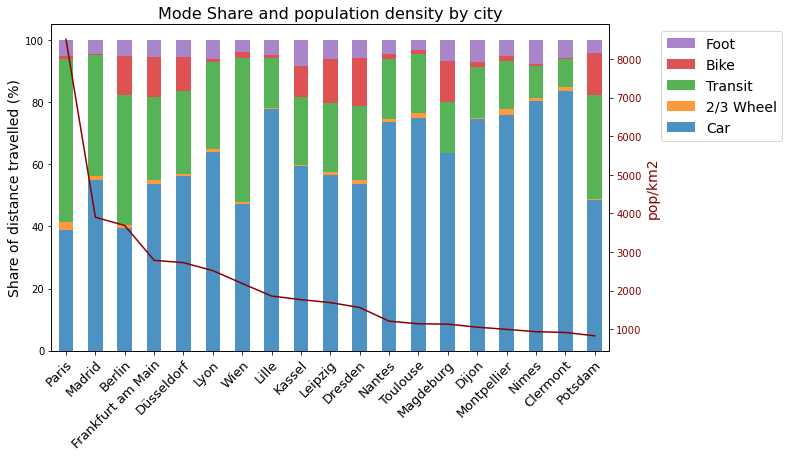

In [19]:
fig, ax1 = plt.subplots(figsize=(10,6))
df_plot.plot(kind='bar', stacked=True,ax=ax1,alpha=0.8)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.08, 1.0),fontsize=14)
ax1.set_xticklabels(df_plot['City'].values)
plt.xticks(rotation = 45,fontsize=13,ha='right',rotation_mode='anchor')
#plt.xlabel('Distance Bands (km)',fontsize=12)
plt.ylabel('Share of distance travelled (%)',fontsize=14)
plt.title('Mode Share and population density by city',fontsize=16)

ax2 = ax1.twinx() 
c='darkred'
ax2.plot(size_sort_dens['City'],size_sort_dens['Pop. density'],color=c)
ax2.set_ylabel('pop/km2', color=c,fontsize=14)
ax2.set_xticklabels(size_sort_dens['City'].values)
ax2.xaxis.set_major_locator(mticker.FixedLocator(xt))
ax2.tick_params(axis='y', labelcolor=c)

plt.savefig('../figures/summary_all/mode_density_bar.png',facecolor='w',dpi=65,bbox_inches='tight')


C:\Users\peter\AppData\Local\Temp\ipykernel_15536\1264331868.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(size_sort_pop['City'].values)


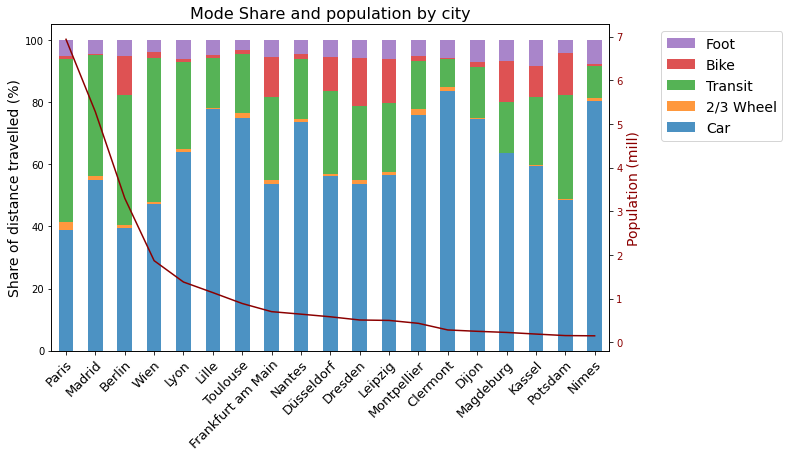

In [19]:
fig, ax1 = plt.subplots(figsize=(10,6))
df_plot2.plot(kind='bar', stacked=True,ax=ax1,alpha=0.8)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.08, 1.0),fontsize=14)
ax1.set_xticklabels(df_plot2['City'].values)
plt.xticks(rotation = 45,fontsize=13,ha='right',rotation_mode='anchor')
plt.ylabel('Share of distance travelled (%)',fontsize=14)
plt.title('Mode Share and population by city',fontsize=16)

ax2 = ax1.twinx() 
c='darkred'
ax2.plot(size_sort_pop['City'],size_sort_pop['Pop.'],color=c)
ax2.set_ylabel('Population (mill)', color=c,fontsize=14)
ax2.set_xticklabels(size_sort_pop['City'].values)
ax2.xaxis.set_major_locator(mticker.FixedLocator(xt))
ax2.tick_params(axis='y', labelcolor=c)
plt.savefig('../figures/summary_all/mode_pop_bar.png',facecolor='w',dpi=65,bbox_inches='tight')

In [ ]:
sHP['Adult']=0
sHP['Child']=0
sHP.loc[sHP['Age']>17,'Adult']=1
sHP.loc[sHP['Age']<18,'Child']=1

Nadult=sHP.loc[:,['HHNR','Adult']].groupby('HHNR')['Adult'].sum().reset_index()
Nadult.rename(columns={'Adult':'N_Adult_HH'},inplace=True)
Nchild=sHP.loc[:,['HHNR','Child']].groupby('HHNR')['Child'].sum().reset_index()
Nchild.rename(columns={'Child':'N_Child_HH'},inplace=True)
sHP=sHP.merge(Nadult)
sHP=sHP.merge(Nchild)

In [ ]:
ages=sHP.loc[:,['HHNR','Age']].groupby('HHNR')['Age'].describe().reset_index() 
ages=ages.loc[:,['HHNR','min','max']]
ages.rename(columns={'min':'minAgeHH','max':'maxAgeHH'},inplace=True)
sHP=sHP.merge(ages)

In [ ]:
sHP['HHType_simp']='Blank'
sHP.loc[(sHP['HHSize']==1) &  (sHP['Sex']==1), 'HHType_simp']='Single_Male'
sHP.loc[(sHP['HHSize']==1) & (sHP['Sex']==2), 'HHType_simp']='Single_Female'

sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']>0) & (sHP['Age']>17) & (sHP['Sex']==1), 'HHType_simp']='Single_Male_Parent' 
sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']>0) & (sHP['Age']>17) & (sHP['Sex']==2), 'HHType_simp']='Single_Female_Parent'

sHP.loc[(sHP['N_Adult_HH']>1) & (sHP['N_Child_HH']>0), 'HHType_simp']='MultiAdult_Kids'

sHP.loc[(sHP['N_Adult_HH']>1) & (sHP['N_Child_HH']==0) , 'HHType_simp']='MultiAdult'

# fill in the type for kids in single parent households
for hh in sHP.loc[sHP['HHType_simp']=='Blank','HHNR']:
    if 'Single_Male_Parent' in sHP.loc[sHP['HHNR']==hh,'HHType_simp'].values:
        sHP.loc[sHP['HHNR']==hh,'HHType_simp']='Single_Male_Parent'
    if 'Single_Female_Parent' in sHP.loc[sHP['HHNR']==hh,'HHType_simp'].values:
        sHP.loc[sHP['HHNR']==hh,'HHType_simp']='Single_Female_Parent'

sHP['HHType_simp'].value_counts()

MultiAdult_Kids         2234
MultiAdult              2156
Single_Female            542
Single_Male              427
Single_Female_Parent     170
Single_Male_Parent        48
Name: HHType_simp, dtype: int64

In [ ]:
sHP['HHType_det']='Blank'
sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']==0) & (sHP['Sex']==1) & (sHP['Age']<40), 'HHType_det']='Single_Male_Under40'
sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']==0) & (sHP['Sex']==2) & (sHP['Age']<40), 'HHType_det']='Single_Female_Under40'

sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']==0) & (sHP['Sex']==1) & (sHP['Age']>39) & (sHP['Age']<65), 'HHType_det']='Single_Male_40-64'
sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']==0) & (sHP['Sex']==2) & (sHP['Age']>39) & (sHP['Age']<65), 'HHType_det']='Single_Female_40-64'

sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']==0) & (sHP['Sex']==1) & (sHP['Age']>64), 'HHType_det']='Single_Male_>64'
sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']==0) & (sHP['Sex']==2) & (sHP['Age']>64), 'HHType_det']='Single_Female_>64'

sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']>0) & (sHP['Age']>17) & (sHP['Sex']==1), 'HHType_det']='Single_Male_Parent' 
sHP.loc[(sHP['N_Adult_HH']==1) & (sHP['N_Child_HH']>0) & (sHP['Age']>17) & (sHP['Sex']==2), 'HHType_det']='Single_Female_Parent'

sHP.loc[(sHP['N_Adult_HH']>1) & (sHP['N_Child_HH']>0), 'HHType_det']='MultiAdult_Kids'

sHP.loc[(sHP['N_Adult_HH']>1) & (sHP['N_Child_HH']==0) & (sHP['minAgeHH']>64), 'HHType_det']='MultiAdult_>65'
sHP.loc[(sHP['N_Adult_HH']>1) & (sHP['N_Child_HH']==0) & (sHP['maxAgeHH']<65), 'HHType_det']='MultiAdult_Under65'
sHP.loc[(sHP['N_Adult_HH']>1) & (sHP['N_Child_HH']==0) & (sHP['minAgeHH']<65) & (sHP['maxAgeHH']>64), 'HHType_det']='MultiAdult_MixGen'

# fill in the type for kids in single parent households
for hh in sHP.loc[sHP['HHType_det']=='Blank','HHNR']:
    if 'Single_Male_Parent' in sHP.loc[sHP['HHNR']==hh,'HHType_det'].values:
        sHP.loc[sHP['HHNR']==hh,'HHType_det']='Single_Male_Parent'
    if 'Single_Female_Parent' in sHP.loc[sHP['HHNR']==hh,'HHType_det'].values:
        sHP.loc[sHP['HHNR']==hh,'HHType_det']='Single_Female_Parent'

sHP['HHType_det'].value_counts()

MultiAdult_Kids          2234
MultiAdult_Under65       1281
MultiAdult_>65            540
MultiAdult_MixGen         335
Single_Female_>64         227
Single_Male_Under40       182
Single_Female_Parent      170
Single_Male_40-64         168
Single_Female_40-64       167
Single_Female_Under40     145
Single_Male_>64            77
Single_Male_Parent         48
Blank                       3
Name: HHType_det, dtype: int64

In [42]:
labels

['2_3_Wheel', 'Bike', 'Car', 'Foot', 'Transit']

In [79]:
# finally plot car mode share and ownership vs income for all cities with income data
inc_de=pd.read_csv('../figures/plots/income_stats_DE.csv')
inc_de['Country']='DE'

inc_fr=pd.read_csv('../figures/plots/income_stats_FR.csv')
inc_fr['Country']='FR'
inc_par=pd.read_csv('../figures/plots/income_stats_Paris.csv')
inc_par['Country']='FR'
inc_fr=pd.concat([inc_fr,inc_par])

inc=pd.concat([inc_de,inc_fr])
inc.reset_index(drop=True,inplace=True)
inc.loc[:,('CarOwnershipHH','Car_ModeShare')]=100*inc.loc[:,('CarOwnershipHH','Car_ModeShare')]
inc=inc.loc[inc['N_HH']>9,]
inc

,Income,CarOwnershipHH,Trip_Distance,Trip_Distance_Car,Car_ModeShare,City,N_HH,Country,CarAvailable
0,350.0,23.595506,13.614649,2.588395,19.011836,Berlin,89.0,DE,NaN
1,700.0,21.179625,14.903775,2.508326,16.830136,Berlin,373.0,DE,NaN
2,1200.0,38.370253,15.483854,4.724651,30.513403,Berlin,1264.0,DE,NaN
3,1750.0,54.021677,15.567102,5.957205,38.267916,Berlin,1753.0,DE,NaN
4,2300.0,66.162109,16.422878,7.064483,43.016111,Berlin,2048.0,DE,NaN
...,...,...,...,...,...,...,...,...,...
98,2700.0,74.661355,14.447788,6.262204,43.343688,Paris,1255.0,FR,NaN
99,3250.0,84.585366,15.198813,6.363078,41.865624,Paris,1025.0,FR,NaN
100,4000.0,88.249211,16.263662,7.035330,43.257971,Paris,1268.0,FR,NaN
101,5000.0,90.887574,16.075022,7.132453,44.369790,Paris,845.0,FR,NaN


In [80]:
inc['Region']=inc['City']
inc.loc[(inc['Country']=='DE') & (inc['City']!='Berlin'),'Region']='DE, other'
inc.loc[(inc['Country']=='FR') & (inc['City']!='Paris'),'Region']='FR, other'
inc

,Income,CarOwnershipHH,Trip_Distance,Trip_Distance_Car,Car_ModeShare,City,N_HH,Country,CarAvailable,Region
0,350.0,23.595506,13.614649,2.588395,19.011836,Berlin,89.0,DE,NaN,Berlin
1,700.0,21.179625,14.903775,2.508326,16.830136,Berlin,373.0,DE,NaN,Berlin
2,1200.0,38.370253,15.483854,4.724651,30.513403,Berlin,1264.0,DE,NaN,Berlin
3,1750.0,54.021677,15.567102,5.957205,38.267916,Berlin,1753.0,DE,NaN,Berlin
4,2300.0,66.162109,16.422878,7.064483,43.016111,Berlin,2048.0,DE,NaN,Berlin
...,...,...,...,...,...,...,...,...,...,...
98,2700.0,74.661355,14.447788,6.262204,43.343688,Paris,1255.0,FR,NaN,Paris
99,3250.0,84.585366,15.198813,6.363078,41.865624,Paris,1025.0,FR,NaN,Paris
100,4000.0,88.249211,16.263662,7.035330,43.257971,Paris,1268.0,FR,NaN,Paris
101,5000.0,90.887574,16.075022,7.132453,44.369790,Paris,845.0,FR,NaN,Paris


In [81]:
inc['Region2']=inc['City']
inc.loc[inc['City'].isin(['Kassel','Magdeburg']),'Region2']='DE, small'
inc.loc[inc['City'].isin(['Frankfurt am Main','Dresden','Leipzig','Düsseldorf']),'Region2']='DE, mid'
inc

,Income,CarOwnershipHH,Trip_Distance,Trip_Distance_Car,Car_ModeShare,City,N_HH,Country,CarAvailable,Region,Region2
0,350.0,23.595506,13.614649,2.588395,19.011836,Berlin,89.0,DE,NaN,Berlin,Berlin
1,700.0,21.179625,14.903775,2.508326,16.830136,Berlin,373.0,DE,NaN,Berlin,Berlin
2,1200.0,38.370253,15.483854,4.724651,30.513403,Berlin,1264.0,DE,NaN,Berlin,Berlin
3,1750.0,54.021677,15.567102,5.957205,38.267916,Berlin,1753.0,DE,NaN,Berlin,Berlin
4,2300.0,66.162109,16.422878,7.064483,43.016111,Berlin,2048.0,DE,NaN,Berlin,Berlin
...,...,...,...,...,...,...,...,...,...,...,...
98,2700.0,74.661355,14.447788,6.262204,43.343688,Paris,1255.0,FR,NaN,Paris,Paris
99,3250.0,84.585366,15.198813,6.363078,41.865624,Paris,1025.0,FR,NaN,Paris,Paris
100,4000.0,88.249211,16.263662,7.035330,43.257971,Paris,1268.0,FR,NaN,Paris,Paris
101,5000.0,90.887574,16.075022,7.132453,44.369790,Paris,845.0,FR,NaN,Paris,Paris


In [82]:
cp=['tab:blue','tab:orange','tab:green','tab:brown','tab:purple','tab:gray','tab:red']

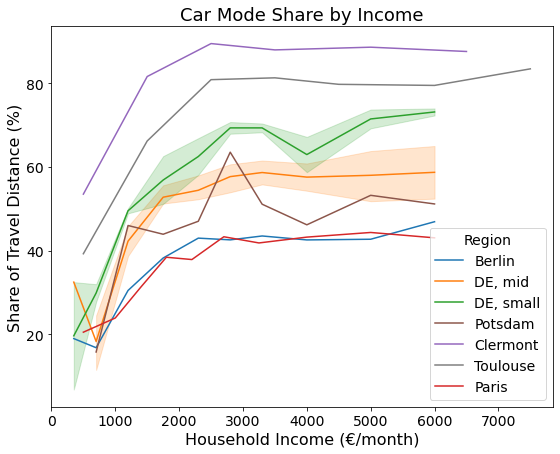

In [32]:
fig, ax = plt.subplots(figsize=(9,7))
sns.lineplot(ax=ax,x='Income', y='Car_ModeShare', data=inc, hue='Region2',alpha=1,palette=cp)
#sns.lineplot(ax=ax,x='Income', y='Car_ModeShare', data=inc.loc[~inc['City'].isin(['Paris','Berlin']),], hue='City',alpha=0.2,legend=False)
#handles, labels = plt.gca().get_legend_handles_labels()
# specify order
#order = [2, 3, 1, 0]
# pass handle & labels lists along with order as below
plt.legend(title='Region', fontsize=14,title_fontsize=14)
plt.title('Car Mode Share by Income',fontsize=18)
#plt.legend(title='Region', fontsize=14)
plt.xlabel('Household Income (€/month)',fontsize=16)
plt.ylabel('Share of Travel Distance (%)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.savefig('../figures/plots/All_CarModeShare_new.png',facecolor='w',dpi=65,bbox_inches='tight')


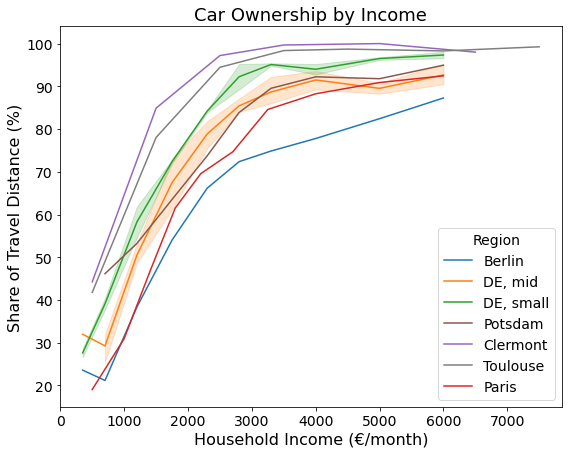

In [84]:
fig, ax = plt.subplots(figsize=(9,7))
sns.lineplot(ax=ax,x='Income', y='CarOwnershipHH', data=inc, hue='Region2',alpha=1,palette=cp)
#sns.lineplot(ax=ax,x='Income', y='Car_ModeShare', data=inc.loc[~inc['City'].isin(['Paris','Berlin']),], hue='City',alpha=0.2,legend=False)
#handles, labels = plt.gca().get_legend_handles_labels()
# specify order
#order = [2, 3, 1, 0]
# pass handle & labels lists along with order as below
plt.legend(title='Region', fontsize=14,title_fontsize=14)
plt.title('Car Ownership by Income',fontsize=18)
#plt.legend(title='Region', fontsize=14)
plt.xlabel('Household Income (€/month)',fontsize=16)
plt.ylabel('Share of Travel Distance (%)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

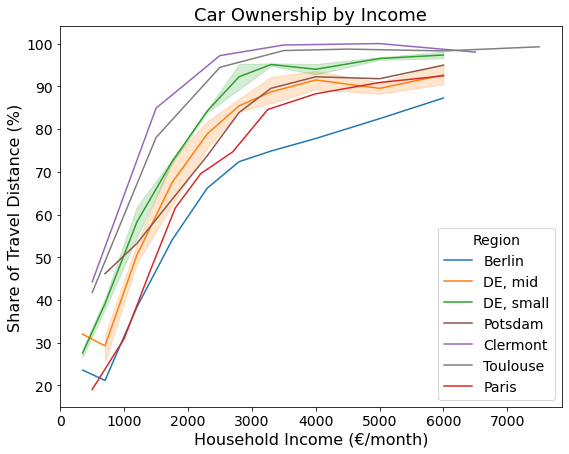

In [85]:
fig, ax = plt.subplots(figsize=(9,7))
sns.lineplot(ax=ax,x='Income', y='CarOwnershipHH', data=inc, hue='Region2',alpha=1,palette=cp)
#sns.lineplot(ax=ax,x='Income', y='Car_ModeShare', data=inc.loc[~inc['City'].isin(['Paris','Berlin']),], hue='City',alpha=0.2,legend=False)
#handles, labels = plt.gca().get_legend_handles_labels()
# specify order
#order = [2, 3, 1, 0]
# pass handle & labels lists along with order as below
plt.legend(title='Region', fontsize=14,title_fontsize=14)
plt.title('Car Ownership by Income',fontsize=18)
#plt.legend(title='Region', fontsize=14)
plt.xlabel('Household Income (€/month)',fontsize=16)
plt.ylabel('Share of Travel Distance (%)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('../figures/plots/All_CarOwnership_new.png',facecolor='w',dpi=65,bbox_inches='tight')
